In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report


In [89]:
random_seed = 112

from model import Model
clusterer = Model(n_components=0.8, cluster_model=ClusterType.gaussian_mixture, random_state= 42)

In [90]:
X_train = clusterer.X_train
X_test = clusterer.X_test
y_train = clusterer.y_train
y_test = clusterer.y_test

In [91]:
# Get clustered data
X_train_clusters = {}
X_test_clusters = {}

for cluster_value in X_train['Cluster'].unique():
    X_train_cluster = X_train[X_train['Cluster'] == cluster_value].drop('Cluster', axis=1)
    X_test_cluster = X_test[X_test['Cluster'] == cluster_value].drop('Cluster', axis=1)
    
    X_train_clusters[f'X_train_{cluster_value}'] = X_train_cluster
    X_test_clusters[f'X_test_{cluster_value}'] = X_test_cluster

cluster_values = list(X_train['Cluster'].unique())

y_train_binary = y_train.astype(int)
y_test_binary = y_test.astype(int)


In [ ]:
# Define the model architecture and training parameters for each cluster
def create_and_train_model(X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster, cluster_num):
    # Model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True),  # Augmenter le nombre de neurones
        tf.keras.layers.Dropout(0.3),  # Ajuster le dropout
        tf.keras.layers.LSTM(32),  # Ajouter plus de couches
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),  # Couche dense supplémentaire
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Calculate class weights for the specific cluster
    cluster_class_weights = compute_class_weight('balanced',
                                               classes=np.unique(y_train_cluster),
                                               y=y_train_cluster.values.ravel())
    cluster_weights = dict(enumerate(cluster_class_weights))
    
    # Train model
    model.fit(
        X_train_cluster,
        y_train_cluster,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        class_weight=cluster_weights,
        verbose=1
    )
    
    # Get predictions
    predictions = model.predict(X_test_cluster)
    predictions_binary = (predictions > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_cluster, predictions_binary)
    balanced_accuracy = balanced_accuracy_score(y_test_cluster, predictions_binary)
    conf_matrix = confusion_matrix(y_test_cluster, predictions_binary)
    

    print(f"\nMetrics for Cluster {cluster_num}:")
    print(f"Accuracy: {accuracy}")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    return model, predictions, predictions_binary, balanced_accuracy

# Train models for each cluster
results = []
balanced_accuracies = []

for cluster_value in cluster_values:
    cluster_num = str(cluster_value)
    print(f"\nTraining model for Cluster {cluster_num}")
    
    # Use the already clustered data
    X_train_reshaped = X_train_clusters[f'X_train_{cluster_num}'].values.reshape((X_train_clusters[f'X_train_{cluster_num}'].shape[0], 1, X_train_clusters[f'X_train_{cluster_num}'].shape[1]))
    X_test_reshaped = X_test_clusters[f'X_test_{cluster_num}'].values.reshape((X_test_clusters[f'X_test_{cluster_num}'].shape[0], 1, X_test_clusters[f'X_test_{cluster_num}'].shape[1]))
    
    # Get corresponding y values
    X_train_cluster = X_train_clusters[f'X_train_{cluster_num}']
    X_test_cluster = X_test_clusters[f'X_test_{cluster_num}']
    y_train_cluster = y_train_binary[y_train_binary.index.isin(X_train_cluster.index)]
    y_test_cluster = y_test_binary[y_test_binary.index.isin(X_test_cluster.index)]
    
    # Train model for this cluster
    model, predictions, predictions_binary, balanced_accuracy = create_and_train_model(
        X_train_reshaped, 
        y_train_cluster, 
        X_test_reshaped, 
        y_test_cluster,
        cluster_num
    )
    
    # Store results
    results.append({
        'cluster': cluster_num,
        'model': model,
        'predictions': predictions,
        'predictions_binary': predictions_binary
    })
    
    # Store balanced accuracy
    balanced_accuracies.append(balanced_accuracy)

# Calculate and print global balanced accuracy
global_balanced_accuracy_LSTM_cluster = np.mean(balanced_accuracies)
print("\n--- Global Results ---")
print(f"Global Balanced Accuracy: {global_balanced_accuracy_LSTM_cluster}")
print("Individual Balanced Accuracies:", balanced_accuracies)


Training model for Cluster 2
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6010 - loss: 0.6639 - val_accuracy: 0.7695 - val_loss: 0.5178
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7918 - loss: 0.4876 - val_accuracy: 0.8184 - val_loss: 0.4630
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8247 - loss: 0.4439 - val_accuracy: 0.8170 - val_loss: 0.4663
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8233 - loss: 0.4486 - val_accuracy: 0.8170 - val_loss: 0.4580
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.4056 - val_accuracy: 0.8184 - val_loss: 0.4557
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8389 - loss: 0.4167 - val_accuracy: 0.8184 - val_loss: 0.4555
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.3884 - val_accuracy: 0.8228 - val_loss: 0.4581
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.4170 - va

In [93]:
from clusterer import Clusterer, ClusterType
clusterer = Clusterer(n_components=0.8)

In [94]:
X_train = clusterer.X_train
X_test = clusterer.X_test
y_train = clusterer.y_train
y_test = clusterer.y_test
X_test = X_test.drop('Cluster', axis=1)
X_train = X_train.drop('Cluster', axis=1)

In [97]:
# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),  # Augmenter le nombre de neurones
    tf.keras.layers.Dropout(0.3),  # Ajuster le dropout
    tf.keras.layers.LSTM(32),  # Ajouter plus de couches
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),  # Couche dense supplémentaire
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights
class_weights = compute_class_weight('balanced',
                                           classes=np.unique(y_train_binary),
                                           y=y_train_binary.values.ravel())
weights = dict(enumerate(class_weights))

X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train model
history = model.fit(
    X_train_reshaped,
    y_train_binary,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=weights,
    verbose=1
)

# Get predictions
predictions = model.predict(X_test_reshaped)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, predictions_binary)
global_balanced_accuracy_LSTM = balanced_accuracy_score(y_test_binary, predictions_binary)
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)

print("\nMetrics for the Model:")
print(f"Accuracy: {accuracy}")
print(f"Balanced Accuracy: {global_balanced_accuracy_LSTM}")
print("\nConfusion Matrix:")
print(conf_matrix)

Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7052 - loss: 0.6029 - val_accuracy: 0.8140 - val_loss: 0.4476
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8183 - loss: 0.4550 - val_accuracy: 0.8220 - val_loss: 0.4572
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8165 - loss: 0.4507 - val_accuracy: 0.8182 - val_loss: 0.4535
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8096 - loss: 0.4550 - val_accuracy: 0.8267 - val_loss: 0.4516
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8089 - loss: 0.4618 - val_accuracy: 0.8206 - val_loss: 0.4583
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8189 - loss: 0.4442 - val_accuracy: 0.8258 - val_loss: 0.4638
Epoch 7/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8259 - loss: 0.4369 - val_accuracy: 0.8173 - val_loss: 0.4634
Epoch 8/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8227 - loss: 0.4368 - val_accuracy: 0.

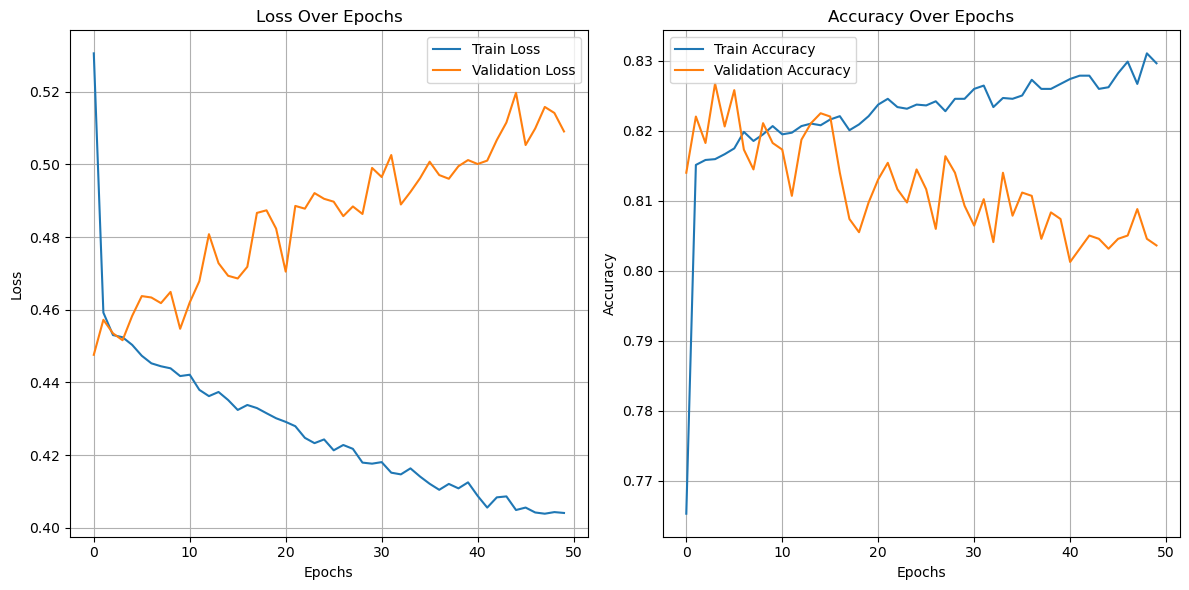

In [98]:
# Extraire les données de l'historique d'entraînement
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Tracer les courbes de perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Tracer les courbes de précision
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()